# Logistic Regression on subscriptions 

The dataset comes from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/index.php), and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y). The dataset can be downloaded [as a CSV file](https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from ggplot import *
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set()

/home/user/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/user/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
data = pd.read_csv("data/banking.csv")

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

In [5]:
# check for missing values 
missing_values = data[data.isnull().any(axis=1)]
missing_values.head()
# alternatively use 
# data.isnull().sum()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y


## Predict variable (desired target) 

> y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

In [6]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

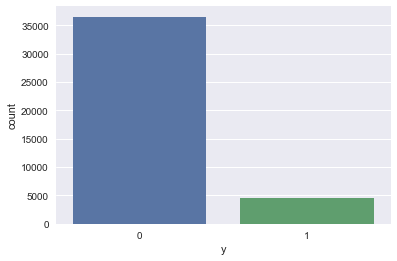

In [7]:
sns.countplot(x='y', data=data)
plt.savefig('count_plot')
plt.show();

In [8]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [9]:
""" --------------------------------------------------------------------
Open Issue: 
How to plot value counts for all variables in dependency of categorical 
variables, see 

URL: https://seaborn.pydata.org/generated/seaborn.countplot.html

- plotting value_counts() in seaborn barplot 
  <https://stackoverflow.com/questions/31460146/>
- Using seaborn barplot to plot wide-form dataframes
  <https://stackoverflow.com/questions/37174715/>

y_0 = data[(data['y'] == 0)].mean()
y_1 = data[(data['y'] == 1)].mean()
data_groupby_y = data.groupby('y').mean()

sns.countplot(x=['age', 'duration'], data=data_groupby_y)
plt.savefig('count_plot')
plt.show();
-------------------------------------------------------------------- """    

" --------------------------------------------------------------------\nOpen Issue: \nHow to plot value counts for all variables in dependency of categorical \nvariables, see \n\nURL: https://seaborn.pydata.org/generated/seaborn.countplot.html\n\n- plotting value_counts() in seaborn barplot \n  <https://stackoverflow.com/questions/31460146/>\n- Using seaborn barplot to plot wide-form dataframes\n  <https://stackoverflow.com/questions/37174715/>\n\ny_0 = data[(data['y'] == 0)].mean()\ny_1 = data[(data['y'] == 1)].mean()\ndata_groupby_y = data.groupby('y').mean()\n\nsns.countplot(x=['age', 'duration'], data=data_groupby_y)\nplt.savefig('count_plot')\nplt.show();\n-------------------------------------------------------------------- "

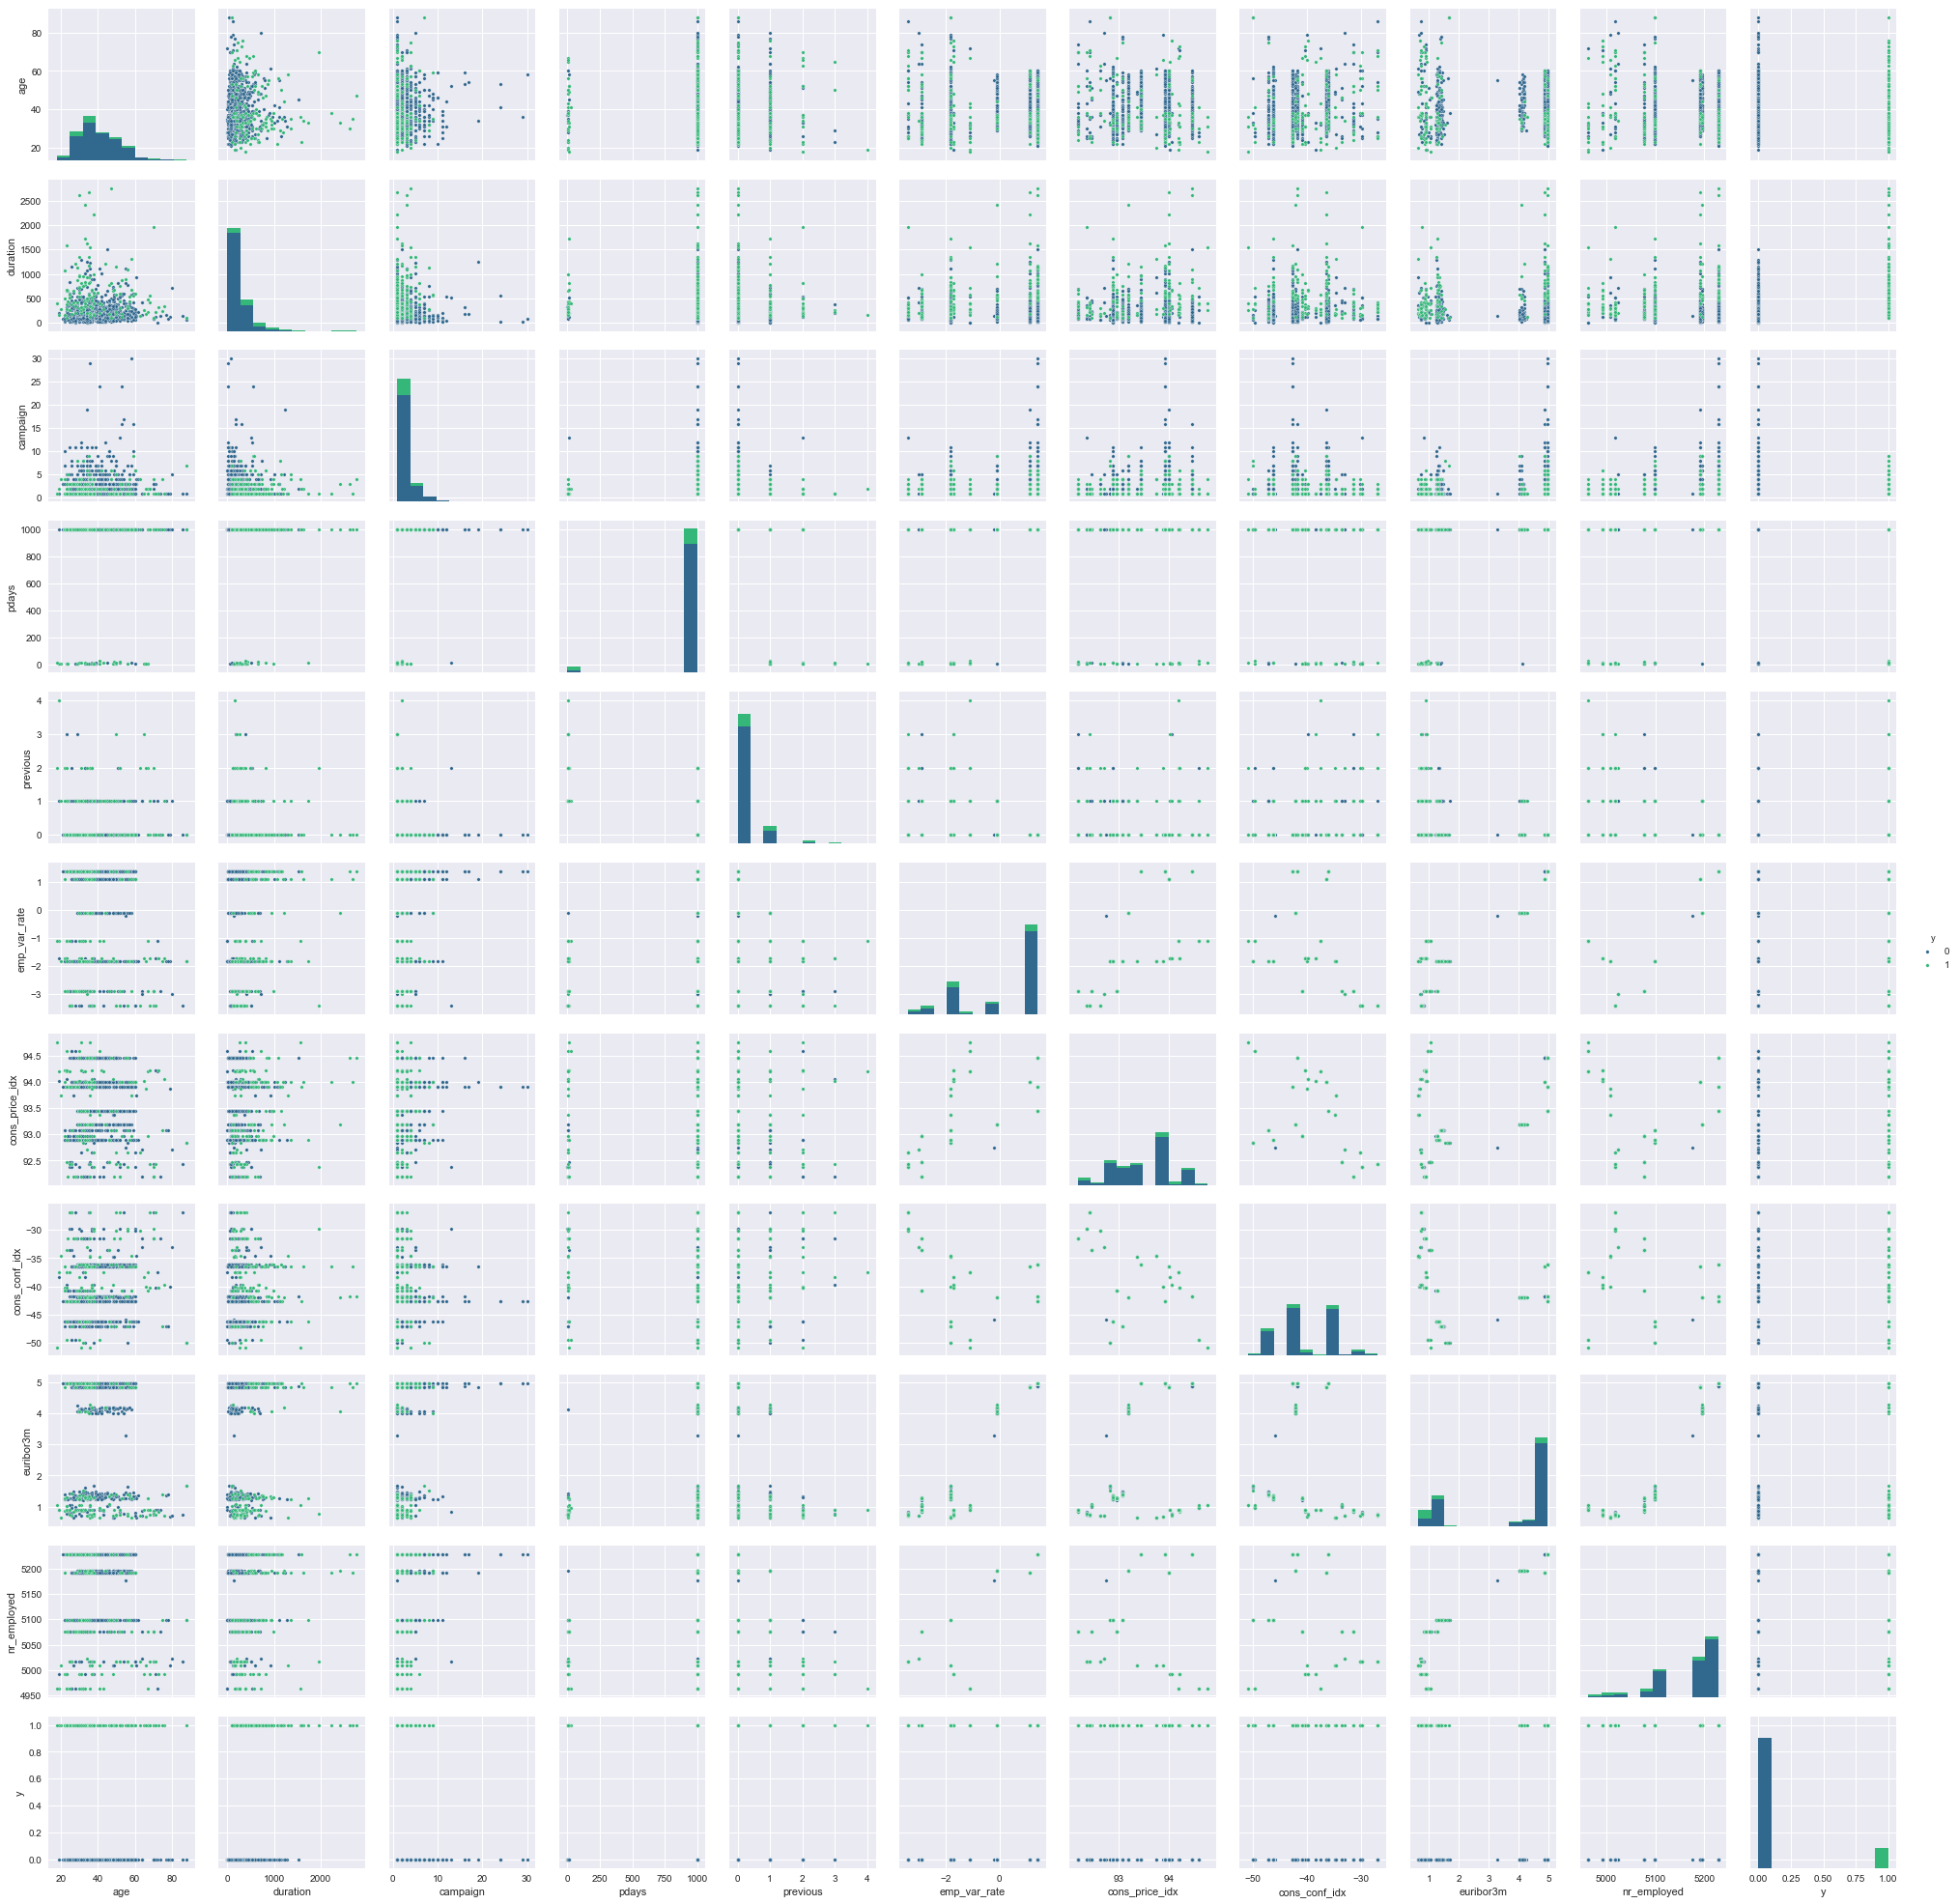

In [10]:
random_sample = data.sample(n=1000, random_state=11)
sns.pairplot(random_sample, hue="y", markers=".", palette="viridis")
plt.savefig('pairplot')
plt.show();

This prediction will be based on 
- the customer’s job, 
- marital status, 
- whether he(she) has credit in default, 
- whether he(she) has a housing loan, 
- whether he(she) has a personal loan, and 
- the outcome of the previous marketing campaigns. 

All other variables will be dropped. 

In [11]:
data.drop(data.columns[[0, 3, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19]], axis=1, inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
job         41188 non-null object
marital     41188 non-null object
default     41188 non-null object
housing     41188 non-null object
loan        41188 non-null object
poutcome    41188 non-null object
y           41188 non-null int64
dtypes: int64(1), object(6)
memory usage: 2.2+ MB


In [13]:
# creates dummy variables 
data2 = pd.get_dummies(data, columns =['job', 'marital', 'default', 'housing', 'loan', 'poutcome'])

In [14]:
data2.head()

,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [15]:
data2.sum()

y                        4640
job_admin.              10422
job_blue-collar          9254
job_entrepreneur         1456
job_housemaid            1060
job_management           2924
job_retired              1720
job_self-employed        1421
job_services             3969
job_student               875
job_technician           6743
job_unemployed           1014
job_unknown               330
marital_divorced         4612
marital_married         24928
marital_single          11568
marital_unknown            80
default_no              32588
default_unknown          8597
default_yes                 3
housing_no              18622
housing_unknown           990
housing_yes             21576
loan_no                 33950
loan_unknown              990
loan_yes                 6248
poutcome_failure         4252
poutcome_nonexistent    35563
poutcome_success         1373
dtype: int64

In [16]:
# Drops the unknown columns
data2.drop(data2.columns[[12, 16, 18, 21, 24]], axis=1, inplace=True)
data2.columns

Index(['y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single', 'default_no',
       'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')

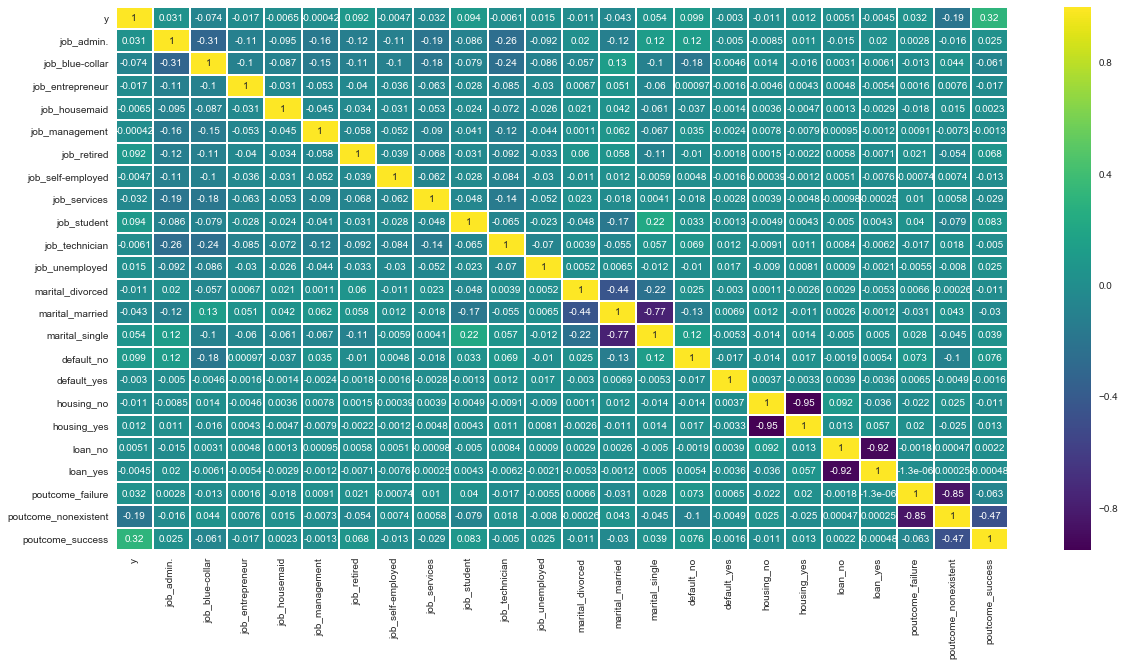

In [17]:
corr_matrix = data2.corr()
plt.subplots(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10}, linewidths=1, cmap='viridis');

In [18]:
X = data2.iloc[:,1:]
y = data2.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [19]:
# Fit logistic regression to the training set
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
y_pred = classifier.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[9046  122]
 [ 906  223]]


In [21]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [22]:
""" --------------------------------------------------------------------
precision: tp / (tp + fp) 
recall: tp / (tp + fn) 
F-beta: a weighted harmonic mean of the precision and recall {0,...,1}
support: number of occurrences of each class in y_test 
-------------------------------------------------------------------- """

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.99      0.95      9168
          1       0.65      0.20      0.30      1129

avg / total       0.88      0.90      0.88     10297



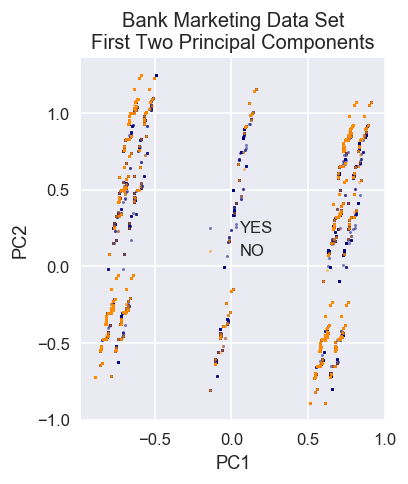

In [23]:
X = data2.iloc[:,1:]
y = data2.iloc[:,0]
pca = PCA(n_components=2).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=11)

plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='YES', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='NO', s=2, color='darkorange')
plt.legend()
plt.title('Bank Marketing Data Set\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

In [24]:
def plot_bank(X, y, fitted_model):
    plt.figure(figsize=(9.8,5), dpi=100)
    for i, plot_type in enumerate(['Decision Boundary', 'Decision Probabilities']):
        plt.subplot(1,2,i+1)
mesh_step_size = 0.01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
        y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size), np.arange(y_min, y_max, mesh_step_size))
        if i == 0:
            Z = fitted_model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            try:
                Z = fitted_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
            except:
                plt.text(0.4, 0.5, 'Probabilities Unavailable', horizontalalignment='center',
                     verticalalignment='center', transform = plt.gca().transAxes, fontsize=12)
                plt.axis('off')
                break
        Z = Z.reshape(xx.shape)
        plt.scatter(X[y.values==0,0], X[y.values==0,1], alpha=0.8, label='YES', s=5, color='navy')
        plt.scatter(X[y.values==1,0], X[y.values==1,1], alpha=0.8, label='NO', s=5, color='darkorange')
        plt.imshow(Z, interpolation='nearest', cmap='RdYlBu_r', alpha=0.15, 
                   extent=(x_min, x_max, y_min, y_max), origin='lower')
        plt.title(plot_type + '\n' + 
                  str(fitted_model).split('(')[0]+ ' Test Accuracy: ' + str(np.round(fitted_model.score(X, y), 5)))
        plt.gca().set_aspect('equal');
    plt.tight_layout()
    plt.legend()
    plt.subplots_adjust(top=0.9, bottom=0.08, wspace=0.02)
model = LogisticRegression()
model.fit(X_train,y_train)
plot_bank(X_test, y_test, model)
plt.show()

IndentationError: unexpected indent (<ipython-input-24-723456c7a797>, line 6)

In [28]:
prob = clf1.predict_proba(Xtest)[:,1] 
fpr, sensitivity, = metrics.roc_curve(Y_test, prob)

NameError: name 'clf1' is not defined

In [26]:
df = pd.DataFrame(dict(fpr=fpr, sensitivity=sensitivity)) ggplot(df, aes(x='fpr', y='sensitivity')) +\ geom_line() +\ geom_abline(linetype='dashed')

SyntaxError: invalid syntax (<ipython-input-26-c8bda82ec392>, line 1)

In [27]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

NameError: name 'logreg' is not defined